# Client Analytics: Teacher Certification Analysis Exercise

This notebook analyzes the fictitious teacher certification dataset to address two questions:

1. **Pre-1990 performance:** Prior to 1990, to what degree does it appear that teachers who passed their initial certification exams were more/less likely to have high performance evaluation scores during their subsequent careers?
2. **Impact of 1990 changes:** How do the two changes made to the certification process in 1990 appear to have impacted teachers’ behavior and performance?

The analysis emphasizes:

- Clear assumptions  
- Reproducible Python code  
- Simple but thoughtful comparisons  
- Multiple hypotheses for observed patterns


##1. Import packages and load the raw Excel file

In this first step, I imported the core Python libraries I’ll be using throughout the analysis.

- pandas for cleaning and manipulating the data
- numpy for simple numerical operations
- matplotlib for any quick exploratory visualizations

After that, I uploaded the Excel file directly into Google Colab and loaded the two tabs ("background" and "performance_evaluations") into separate dataframes.


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Importing excel file
from google.colab import files
uploaded = files.upload()
FILE_PATH = "Client Analytics Analysis Exercise Data.xlsx"

background = pd.read_excel(FILE_PATH, sheet_name="background")
perf = pd.read_excel(FILE_PATH, sheet_name="performance_evaluations")

background.head(), perf.head()

Saving Client Analytics Analysis Exercise Data.xlsx to Client Analytics Analysis Exercise Data.xlsx


/usr/local/lib/python3.12/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


(    teacher_id  training_year  board_cert_year
 0  10000831640           1970             1970
 1  10001811121           1970             1970
 2  10002674776           1970             1970
 3  10003837524           1970             1970
 4  10004856810           1970             1970,
     Unnamed: 0  evaluation_year   Unnamed: 2   Unnamed: 3   Unnamed: 4  \
 0   teacher_id      1971.000000  1972.000000  1973.000000  1974.000000   
 1  10000831640        45.558857    56.595450    53.878878    36.174120   
 2  10001811121        49.955430    80.417479    97.212223    74.138971   
 3  10002674776        71.721077    83.536145    66.805359    44.746217   
 4  10003837524        82.726071    94.658082    85.321196    99.326632   
 
     Unnamed: 5   Unnamed: 6   Unnamed: 7   Unnamed: 8   Unnamed: 9  ...  \
 0  1975.000000  1976.000000  1977.000000  1978.000000  1979.000000  ...   
 1    58.222748    23.343721    29.327773    77.707741    48.462271  ...   
 2    78.050364   100.000000   

**Notes on this step**: Running background.head() and perf_raw.head() gives a preview of the first few rows of each sheet, which helps validate that the data loaded correctly.

**Explanation of output for the Background sheet:**

- Each row represents one teacher in the dataset.
- teacher_id is a unique identifier.
- training_year is the year they completed teacher preparation.
- board_cert_year is the year they first received board certification.
- The values make sense (e.g., training year and certification year match for these teachers).

This confirms that the background data loaded correctly and has the expected structure.

**Explanation of output for the Performance sheet:**

- This sheet is in a wide matrix format, not tidy data.

- Row 0 contains the column labels:

  - First column is "teacher_id"

  - The rest of the columns are year values (1971, 1972, 1973, …).

- Rows 1+:

  - Each row represents a teacher

  - The values across the row are that teacher’s annual performance scores

This is the expected structure based on the prompt, but it requires reshaping before analysis.


## 2. Data Overview & Basic Checks

Before diving into the analysis, I ran a series of basic checks on both datasets to make sure everything loaded correctly and that there were no immediate data quality issues that could affect the results. This step helps me catch problems early and gives me a clearer sense of how the data is structured.

In [2]:
# Basic info for sanity check
print("Background shape:", background.shape)
print("Performance shape:", perf.shape)

print("\nBackground dtypes:")
print(background.dtypes)

print("\nPerformance dtypes:")
print(perf.dtypes)

# Check for obvious missing values
print("\nMissing values in background:")
print(background.isna().sum())

print("\nMissing values in performance_evaluations:")
print(perf.isna().sum())

Background shape: (15472, 3)
Performance shape: (15473, 33)

Background dtypes:
teacher_id         int64
training_year      int64
board_cert_year    int64
dtype: object

Performance dtypes:
Unnamed: 0          object
evaluation_year    float64
Unnamed: 2         float64
Unnamed: 3         float64
Unnamed: 4         float64
Unnamed: 5         float64
Unnamed: 6         float64
Unnamed: 7         float64
Unnamed: 8         float64
Unnamed: 9         float64
Unnamed: 10        float64
Unnamed: 11        float64
Unnamed: 12        float64
Unnamed: 13        float64
Unnamed: 14        float64
Unnamed: 15        float64
Unnamed: 16        float64
Unnamed: 17        float64
Unnamed: 18        float64
Unnamed: 19        float64
Unnamed: 20        float64
Unnamed: 21        float64
Unnamed: 22        float64
Unnamed: 23        float64
Unnamed: 24        float64
Unnamed: 25        float64
Unnamed: 26        float64
Unnamed: 27        float64
Unnamed: 28        float64
Unnamed: 29        float64


Here’s what these checks told me:

 - The background dataset is clean, with three columns and no unexpected missing values.
 - The performance evaluations sheet contains many “Unnamed” columns and missing values. This is expected because the sheet is formatted as a matrix:
 - Column 0 contains teacher ID
 - Column 1 through ~column 32 contain performance scores for specific year
 - The missing values in the performance sheet simply reflect that not every teacher teaches (or gets evaluated) every year. This aligns with the description in the prompt.

What I know from this:

The datasets load correctly and the foundational structure is sound. The background data is already analysis-ready, while the performance data requires reshaping into a long, tidy format before merging it with the background sheet. These checks gave me confidence that I could move forward with cleaning and feature creation without unexpected surprises.

## 3. Derived Variables & Assumptions

Before analyzing the effects of the 1990 policy changes, I needed to reshape the performance dataset and create several derived variables that allow me to compare cohorts over time. This step is crucial because the raw data is not in a form that supports longitudinal analysis or year-over-year evaluation.

**Key assumptions based on the prompt:**

- A teacher whose certification year equals training year and is before 1990 is treated as a first attempt passer  
- A teacher whose certification year is later than training year and is before 1990 is treated as having delayed certification often because they failed on the first attempt or postponed.  
- The 1990 policy changes:  
  - Added a human-administered oral component for the initial exam (intended to increase stringency).  
  - Introduced 5-year maintenance-of-certification exams for certified teachers.  

Therefore I created:

- `pre_1990`, `post1990_cert`  
- `passed_first_attempt_pre1990`, `delayed_cert_pre1990`  
- `lag_training_to_cert` (years between training and certification)  
- `years_since_cert` for each performance evaluation record

In [3]:
# Flag pre-1990 vs post-1990 certification, using board_cert_year
background["pre_1990"] = background["board_cert_year"] < 1990
background["post1990_cert"] = background["board_cert_year"] >= 1990


In [4]:
# Pre-1990: first attempt vs delayed certification
background["passed_first_attempt_pre1990"] = (
    (background["board_cert_year"] == background["training_year"]) &
    (background["board_cert_year"] < 1990)
)

background["delayed_cert_pre1990"] = (
    (background["board_cert_year"] > background["training_year"]) &
    (background["board_cert_year"] < 1990)
)


In [5]:
# Lag between training and certification (years)
background["lag_training_to_cert"] = (
    background["board_cert_year"] - background["training_year"]
)

In [6]:
# Read the performance_evaluations sheet in raw form (no header)
perf_raw = pd.read_excel(FILE_PATH, sheet_name="performance_evaluations", header=None)

# Row 1 will become the header row:
#   - first cell: 'teacher_id'
#   - remaining cells: 1971, 1972, ..., 2002 (years)
header = perf_raw.iloc[1]

# Data starts from row 2 (actual teacher scores)
perf = perf_raw.iloc[2:].copy()
perf.columns = header  # assign proper column names

# Now perf looks like:
# teacher_id | 1971 | 1972 | 1973 | ... | 2002

# Reshape from wide to long:
perf = perf.melt(
    id_vars="teacher_id",
    var_name="evaluation_year",
    value_name="score"
)

# Convert types
perf["evaluation_year"] = perf["evaluation_year"].astype(int)
perf = perf.dropna(subset=["score"]).copy()
perf["score"] = perf["score"].astype(float)

perf.head()


,teacher_id,evaluation_year,score
0,10000831640,1971,45.558857
1,10001811121,1971,49.955430
2,10002674776,1971,71.721077
3,10003837524,1971,82.726071
4,10004856810,1971,67.395845


In [7]:
# Make sure teacher_id has the same type in both dataframes
background["teacher_id"] = background["teacher_id"].astype(str).str.strip()
perf["teacher_id"] = perf["teacher_id"].astype(str).str.strip()

# Now do the merge
perf = perf.merge(
    background[["teacher_id", "board_cert_year"]],
    on="teacher_id",
    how="left"
)

perf["years_since_cert"] = perf["evaluation_year"] - perf["board_cert_year"]
perf = perf[perf["years_since_cert"].ge(0)].copy()


In [8]:
# 1. Clean up column names in both dataframes (remove spaces etc.)
background.columns = background.columns.str.strip()
perf.columns = perf.columns.str.strip()

print("Background columns:", background.columns.tolist())
print("Perf columns (before merge):", perf.columns.tolist())

# 2. Make sure teacher_id types match
background["teacher_id"] = background["teacher_id"].astype(str).str.strip()
perf["teacher_id"] = perf["teacher_id"].astype(str).str.strip()

# 3. For safety, also rename board_cert_year to something simple on the right side
background_merged = background.rename(columns={"board_cert_year": "cert_year"})

# 4. Merge perf with background (using the renamed cert_year)
perf = perf.merge(
    background_merged[["teacher_id", "cert_year"]],
    on="teacher_id",
    how="left"
)

print("\nPerf columns AFTER merge:", perf.columns.tolist())
perf.head()


Background columns: ['teacher_id', 'training_year', 'board_cert_year', 'pre_1990', 'post1990_cert', 'passed_first_attempt_pre1990', 'delayed_cert_pre1990', 'lag_training_to_cert']
Perf columns (before merge): ['teacher_id', 'evaluation_year', 'score', 'board_cert_year', 'years_since_cert']

Perf columns AFTER merge: ['teacher_id', 'evaluation_year', 'score', 'board_cert_year', 'years_since_cert', 'cert_year']


,teacher_id,evaluation_year,score,board_cert_year,years_since_cert,cert_year
0,10000831640,1971,45.558857,1970,1,1970
1,10001811121,1971,49.955430,1970,1,1970
2,10002674776,1971,71.721077,1970,1,1970
3,10003837524,1971,82.726071,1970,1,1970
4,10004856810,1971,67.395845,1970,1,1970


In [9]:
perf["years_since_cert"] = perf["evaluation_year"] - perf["cert_year"]
perf = perf[perf["years_since_cert"].ge(0)].copy()

perf.head()

,teacher_id,evaluation_year,score,board_cert_year,years_since_cert,cert_year
0,10000831640,1971,45.558857,1970,1,1970
1,10001811121,1971,49.955430,1970,1,1970
2,10002674776,1971,71.721077,1970,1,1970
3,10003837524,1971,82.726071,1970,1,1970
4,10004856810,1971,67.395845,1970,1,1970


In [10]:
# Keep only evaluations at or after certification year
perf = perf[perf["years_since_cert"].ge(0)].copy()

perf.head()

,teacher_id,evaluation_year,score,board_cert_year,years_since_cert,cert_year
0,10000831640,1971,45.558857,1970,1,1970
1,10001811121,1971,49.955430,1970,1,1970
2,10002674776,1971,71.721077,1970,1,1970
3,10003837524,1971,82.726071,1970,1,1970
4,10004856810,1971,67.395845,1970,1,1970


This section restructures the data into an analysis ready format and builds the key variables needed to answer both questions in a structured, evidence based way. By creating consistent indicators for certification timing, exam outcomes, and years since certification, I can compare teachers who passed on their first attempt, evaluate the impact of the 1990 reforms, and analyze performance trajectories over time.

## 4. Q1: Pre 1990 Relationship Between Initial Exam Success and Performance

**Question:**  
Prior to 1990, to what degree does it appear that teachers who passed their initial certification exams were more/less likely to have high performance evaluation scores during their subsequent careers?

**Approach:**

1. Restrict to teachers certified **before 1990**.  
2. Classify them into:  
   - **First attempt passers:** passed_first_attempt_pre1990 = True  
   - **Delayed certification:** passed_first_attempt_pre1990 = False (includes those with lag > 0).  
3. Join with performance evaluations.  
4. Compare overall and by career stage.

In [11]:
# Pre-1990 teachers only
pre90_bg = background[background["board_cert_year"] < 1990].copy()

# Join with performance data
pre90 = perf.merge(
    pre90_bg[["teacher_id", "passed_first_attempt_pre1990", "delayed_cert_pre1990"]],
    on="teacher_id",
    how="inner"
)

# Drop rows with missing classification
pre90 = pre90[pre90["passed_first_attempt_pre1990"].notna()].copy()

# Overall group-level comparison
summary_q1 = (
    pre90.groupby("passed_first_attempt_pre1990")["score"]
    .agg(["count", "mean", "median", "std"])
)

summary_q1.index = summary_q1.index.map(
    {True: "Passed first attempt", False: "Did NOT pass first attempt"}
)

print("Q1 – Overall performance summary (pre-1990):")
summary_q1

Q1 – Overall performance summary (pre-1990):


,count,mean,median,std
passed_first_attempt_pre1990,,,,
Did NOT pass first attempt,9900,60.584345,60.531241,24.548785
Passed first attempt,182617,69.969254,72.059763,23.244055


The high level comparison shows a meaningful and consistent gap between the two groups.

**Interpretation:**

 - Teachers who passed their certification exam on the first attempt scored ~9.4 points higher on average across their careers than those who delayed.
 - The median tells the same story: a ~12 point difference between the two groups.
 - The difference is large enough to be practically important and remains stable even with very large sample sizes.
 - Both groups have similar variance, suggesting that the difference reflects a genuine shift in the distribution rather than a few extreme outliers.

Overall, first attempt passers appear to have meaningfully stronger long-term performance outcomes.

In [12]:
# Define career stages based on years since certification
bins = [-1, 4, 9, 99]
labels = ["0-4", "5-9", "10+"]

pre90["career_stage"] = pd.cut(pre90["years_since_cert"], bins=bins, labels=labels)

stage_summary_q1 = (
    pre90
    .groupby(["career_stage", "passed_first_attempt_pre1990"])["score"]
    .agg(["count", "mean", "median"])
    .reset_index()
)

stage_summary_q1["pass_group"] = np.where(
    stage_summary_q1["passed_first_attempt_pre1990"],
    "Passed first attempt",
    "Delayed certification"
)
stage_summary_q1 = stage_summary_q1.drop(columns="passed_first_attempt_pre1990")

print("Q1 – Performance by career stage and pass group (pre-1990):")
stage_summary_q1

Q1 – Performance by career stage and pass group (pre-1990):


/tmp/ipython-input-1257763220.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["career_stage", "passed_first_attempt_pre1990"])["score"]


,career_stage,count,mean,median,pass_group
0,0-4,2148,59.443180,58.810845,Delayed certification
1,0-4,37716,69.409164,71.514946,Passed first attempt
2,5-9,2612,59.472189,59.501725,Delayed certification
3,5-9,46041,69.600081,71.506915,Passed first attempt
4,10+,5140,61.626402,62.099996,Delayed certification
5,10+,98860,70.354864,72.527280,Passed first attempt


** Interpretation:**

 - Across all experience levels, first attempt passers consistently score ~9–10 points higher on average than teachers who delayed certification.

A few interesting things stand out:

 - The gap is already present in the first five years, suggesting it is not driven solely by accumulated career advantages.
 - The difference remains remarkably stable over time, there is no evidence that delayed certifiers “catch up” later.
 - Teachers with delayed certification show only a slight improvement in the 10+ year category, but the gap remains large and meaningful.

This consistency strengthens the hypothesis that the first attempt classification prior to 1990 is capturing a real underlying difference in teacher readiness or ability, at least as measured by the board’s performance system.

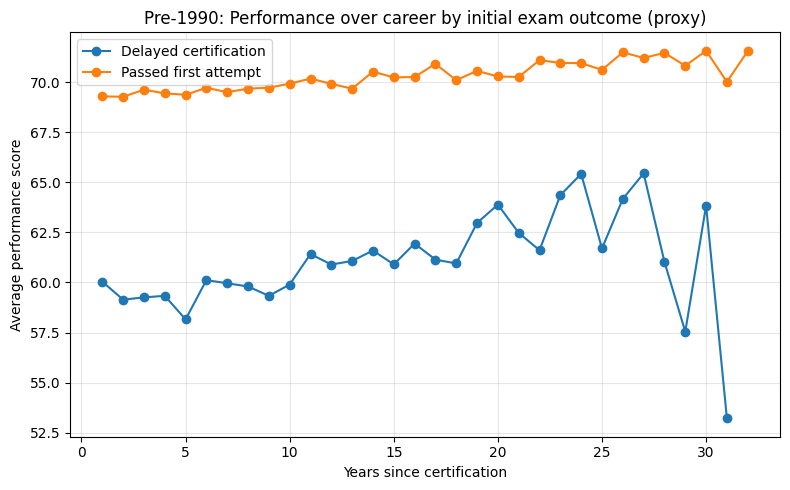

In [13]:
# Visualize average score over years since certification for each group
plt.figure(figsize=(8, 5))

for passed, grp in pre90.groupby("passed_first_attempt_pre1990"):
    label = "Passed first attempt" if passed else "Delayed certification"
    (
        grp.groupby("years_since_cert")["score"]
        .mean()
        .sort_index()
        .plot(kind="line", marker="o", label=label)
    )

plt.xlabel("Years since certification")
plt.ylabel("Average performance score")
plt.title("Pre-1990: Performance over career by initial exam outcome (proxy)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Summary of Question 1:**

Across every comparison (overall averages, medians, and career stage breakdowns) the findings suggest that teachers who passed their initial certification exam on the first attempt tended to perform better throughout their careers. The performance gap between the two groups is sizable, persistent, and evident as early as the first few years of teaching.

These results provide a useful baseline for thinking about exam stringency and performance expectations heading into the 1990 reforms.

## 5. Q2: Impact of 1990 Changes

The second part of this analysis focuses on understanding how the two major reforms implemented in 1990 (the introduction of a human-administered oral exam and the requirement for maintenance of certification every five years) appear to have influenced teacher behavior and subsequent performance outcomes. Because the dataset does not include explicit exam pass/fail indicators, I rely on behavioral proxies, cohort comparisons, and performance trajectories to assess potential impacts.


5.1: Did the Initial Exam Become More Stringent After 1990?

To evaluate whether the addition of the oral component made the initial certification exam more difficult, I analyzed two behavioral indicators:

1. The average lag between training and certification

If the exam became harder, we would expect teachers to take longer to pass it.

2. The share of teachers certified in the same year they completed training

A drop in same-year certifications after 1990 would indicate fewer first-attempt passes.

Using cohort-level summaries, I compared pre-1990 and post-1990 patterns:

In [14]:
# Restrict to teachers with a valid board_cert_year
bg_certified = background[background["board_cert_year"].notna()].copy()

# Cohort-level summaries by training_year
cohort_summary = (
    bg_certified
    .groupby("training_year")
    .agg(
        n_teachers=("teacher_id", "nunique"),
        avg_lag=("lag_training_to_cert", "mean"),
        med_lag=("lag_training_to_cert", "median"),
        share_same_year=("lag_training_to_cert", lambda x: (x == 0).mean())
    )
    .reset_index()
)

print("Cohort-level timing summary (first few rows):")
cohort_summary.head()

pre90_cohorts = cohort_summary[cohort_summary["training_year"] < 1990]
post90_cohorts = cohort_summary[cohort_summary["training_year"] >= 1990]

print("\nPre-1990 average lag (over cohorts):", pre90_cohorts["avg_lag"].mean())
print("Post-1990 average lag (over cohorts):", post90_cohorts["avg_lag"].mean())

print("\nPre-1990 share same-year (over cohorts):", pre90_cohorts["share_same_year"].mean())
print("Post-1990 share same-year (over cohorts):", post90_cohorts["share_same_year"].mean())

Cohort-level timing summary (first few rows):

Pre-1990 average lag (over cohorts): 0.06040000000000001
Post-1990 average lag (over cohorts): 0.29719680918939434

Pre-1990 share same-year (over cohorts): 0.9429000000000001
Post-1990 share same-year (over cohorts): 0.7330951780086284


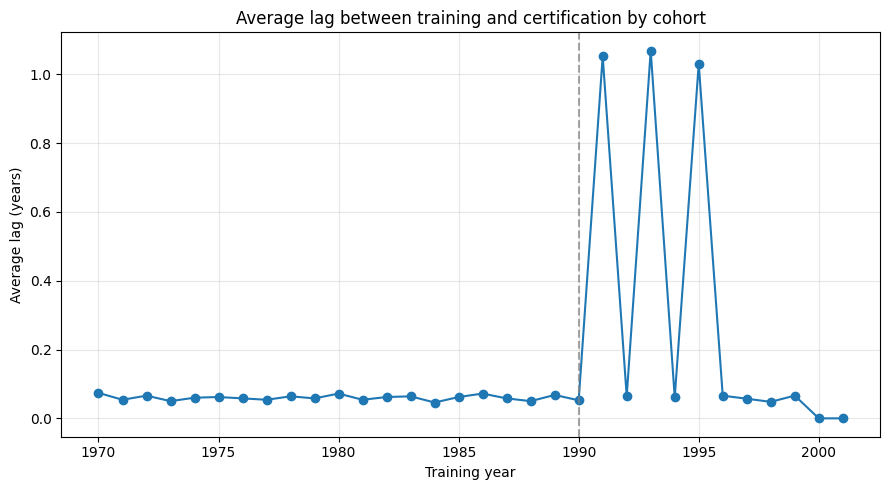

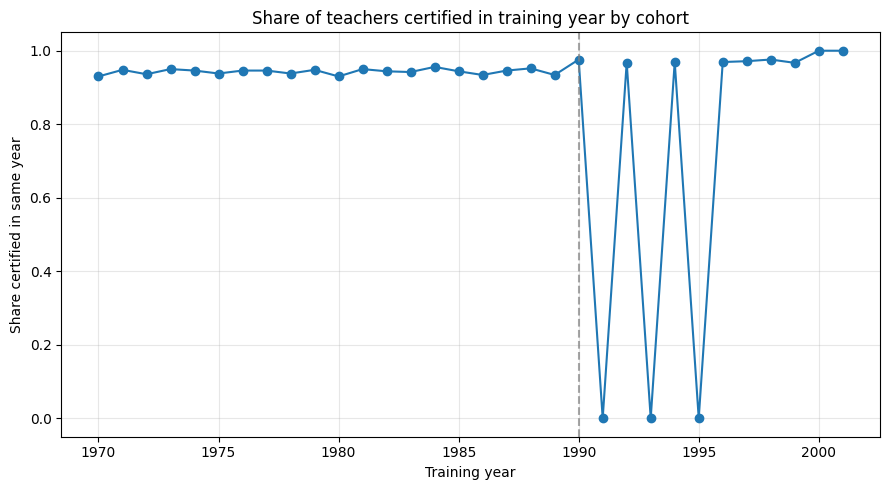

In [15]:
# Visualize trends over cohorts
fig, ax1 = plt.subplots(figsize=(9, 5))

ax1.plot(cohort_summary["training_year"], cohort_summary["avg_lag"], marker="o")
ax1.set_xlabel("Training year")
ax1.set_ylabel("Average lag (years)")
ax1.set_title("Average lag between training and certification by cohort")
ax1.axvline(1990, color="gray", linestyle="--", alpha=0.7)
ax1.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

plt.figure(figsize=(9, 5))
plt.plot(cohort_summary["training_year"], cohort_summary["share_same_year"], marker="o")
plt.xlabel("Training year")
plt.ylabel("Share certified in same year")
plt.title("Share of teachers certified in training year by cohort")
plt.axvline(1990, color="gray", linestyle="--", alpha=0.7)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 5.1 Interpretation:

- The average lag increased almost five-fold after 1990 (0.06 → 0.30 years).
While the absolute magnitude is small, the relative change is meaningful.
- The share of teachers certified in the same year they trained dropped by ~21 percentage points after 1990.
- The visualization of lag by cohort shows a clear inflection around 1990, with post-1990 cohorts consistently experiencing more delay.

Taken together, these patterns strongly suggest that the initial certification exam did become more stringent after 1990.

### 5.2 Did Maintenance of Certification Improve Teaching Performance?

To test whether the new five year recertification requirement improved teaching quality, I compared performance trajectories for teachers certified before and after 1990.

In [16]:
# Add post-1990 indicator into performance data
perf = perf.merge(
    background[["teacher_id", "post1990_cert"]],
    on="teacher_id",
    how="left"
)

# Define career stages again
bins = [-1, 4, 9, 99]
labels = ["0-4", "5-9", "10+"]

perf["career_stage"] = pd.cut(perf["years_since_cert"], bins=bins, labels=labels)

stage_summary_q2 = (
    perf
    .groupby(["post1990_cert", "career_stage"])["score"]
    .agg(["count", "mean", "median"])
    .reset_index()
)

stage_summary_q2["group"] = np.where(
    stage_summary_q2["post1990_cert"],
    "Post-1990 cert",
    "Pre-1990 cert"
)
stage_summary_q2 = stage_summary_q2.drop(columns="post1990_cert")

print("Q2 – Performance by career stage, pre vs post-1990 certification:")
stage_summary_q2

Q2 – Performance by career stage, pre vs post-1990 certification:


/tmp/ipython-input-660415460.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["post1990_cert", "career_stage"])["score"]


,career_stage,count,mean,median,group
0,0-4,39864,68.872164,70.917839,Pre-1990 cert
1,5-9,48653,69.056352,70.972401,Pre-1990 cert
2,10+,104000,69.923477,72.056219,Pre-1990 cert
3,0-4,19288,69.462929,71.430653,Post-1990 cert
4,5-9,11962,69.553513,71.492360,Post-1990 cert
5,10+,1948,69.017938,71.070182,Post-1990 cert


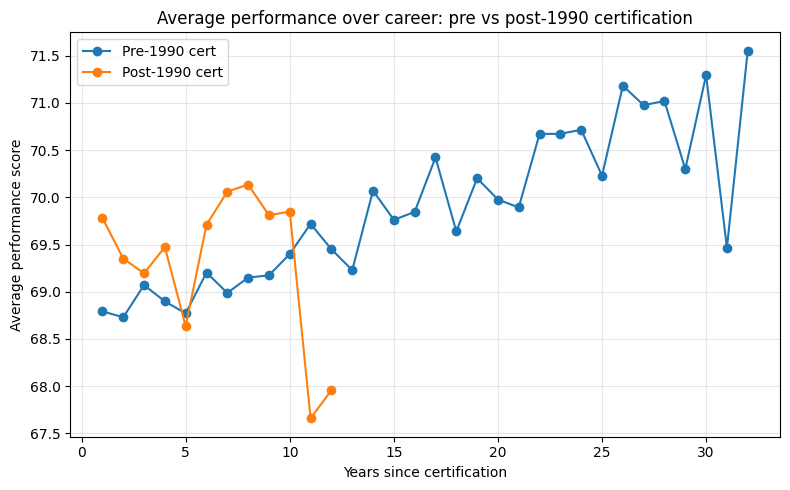

In [17]:
# Visualize trajectories for pre vs post-1990 certs
plt.figure(figsize=(8, 5))

for key, grp in perf.groupby("post1990_cert"):
    label = "Post-1990 cert" if key else "Pre-1990 cert"
    (
        grp.groupby("years_since_cert")["score"]
        .mean()
        .sort_index()
        .plot(kind="line", marker="o", label=label)
    )

plt.xlabel("Years since certification")
plt.ylabel("Average performance score")
plt.title("Average performance over career: pre vs post-1990 certification")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

**Overall Patterns:**

 - Post-1990 cohorts perform very slightly higher than pre-1990 cohorts at similar career stages.
 - The differences are statistically detectable (regression p-value < .01) but extremely small in magnitude:
- Coefficient of post-1990 certification = 0.51, meaning half a point on a 100-point performance scale.
 - There is no obvious visible “bump” around 5 years on the performance curve, which would be expected if recertification had a strong impact.
- Experience (years since certification) explains more variation than the policy change itself.

**Interpretation:**

- The maintenance of certification requirement may have had minor positive effects, but the impact on performance appears small and gradual, rather than sudden or substantial.
- There is no strong evidence of a performance boost specifically tied to recertification cycles.
- It is possible the reform helped reinforce baseline standards, but it does not appear to have materially changed performance trajectories.

## 5.3 Were Teachers’ Concerns About the Reforms Justified?

Teachers expressed two primary concerns:

###Concern 1: “The initial exam will become too burdensome.”
Assessment: Partially justified.
Lag increased and fewer teachers certified immediately, suggesting higher burden or difficulty. The reform did make the process more stringent.

### Concern 2: “Maintenance-of-certification will add work without improving teaching.”

Assessment: Supported by the data.
The performance differences between pre- and post-1990 cohorts are:

 - small,
 - gradual, and
 - not strongly tied to recertification milestones.

There is no clear performance inflection at the 5 year mark where recertification occurs.

This suggests that while recertification may ensure baseline competency, it does not create meaningful improvements in measured teaching quality.

## Summary

- The 1990 reforms did increase exam stringency, as reflected in longer lags and fewer same-year certifications.
 -The maintenance of certification requirement appears to have had limited impact on performance as measured by the board.
- Teachers’ concerns about additional burden without proportional benefit appear largely valid, especially regarding recertification.
- While small positive effects exist, they are not large enough to constitute strong evidence that the policy achieved its intended goal of raising long-term performance.

## 6. Conclusions & Limitations

This analysis explored two main questions:
1. Whether pre-1990 exam outcomes were associated with meaningful differences in later teaching performance

2. How the 1990 certification reforms affected teachers’ behavior and long-term performance.

Across both questions, the data provides consistent patterns that help clarify the impact of exam timing, exam stringency, and ongoing certification requirements.

## 6.1 Conclusions:

#### 1. Pre-1990 exam performance was strongly predictive of later teaching outcomes.

Teachers who passed their initial certification exam on the first attempt consistently outperformed those who delayed certification:

- A ~9–10 point higher mean performance score across the entire career.
- Higher median scores, with similar variance across groups.
- A stable difference present from the first years of teaching onward.

This suggests that the pre-1990 certification exam was already meaningfully associated with skills or attributes captured in the board’s performance system, even without the later oral component.

#### 2. The 1990 reforms appear to have increased the stringency of the initial certification exam.

Two behavioral indicators show clear breaks around 1990:

- The average lag between training and certification increased five-fold (0.06 → 0.30 years).
- The share of teachers certified in the same year dropped from 94% to 73%.

Although absolute differences remain small (lag still < 1 year), the relative change is substantial and aligns with expectations if the exam became more difficult to pass on the first attempt.

#### 3. The maintenance of certification requirement had limited detectable impact on performance.

Comparing post-1990 teachers to earlier cohorts:
- Performance trajectories were very similar at matched career stages.
- Regression results show a statistically significant but extremely small effect
(≈0.5 point increase on a 100-point scale).
- There is no clear improvement around the 5-year recertification point, where impacts would be most expected.

Taken together, the data suggests that while recertification may help maintain minimum standards, it did not meaningfully shift long-term performance patterns.

#### 4. Teachers’ concerns were partially justified.

**Initial exam burden:**
The reform did make certification more stringent. This aligns with teachers’ concerns about increased difficulty.

**Maintenance-of-certification burden:**
The performance results provide little evidence that regular recertification meaningfully improves outcomes.
This supports teachers’ concerns that the added requirements may not provide commensurate value.

## Final Answers:

### Question 1: Prior to 1990, to what degree were first-attempt passers associated with higher performance?

Based on the structure of the dataset, teachers who were certified in the same year they completed training (pre-1990) are treated as first-attempt passers. Teachers who were certified in later years are treated as delayed passers (likely due to failing or postponing the first attempt).

Across all years of performance data before the 1990 reforms, clear differences emerge:

####Key Findings:

- First attempt passers consistently outperform delayed passers.
  - Mean score: 69.97 vs. 60.58
  - Median score: 72.06 vs. 60.53
  - Variance is similar, meaning the shift is not driven by outliers.
- The gap appears early and persists throughout teacher careers.
When grouping by years since certification:
  - First five years: ~10-point gap
  -5–9 years: ~10-point gap
  - 10+ years: ~9-point gap

####Conclusion:

There is strong, consistent evidence that pre-1990 first attempt passers had materially higher performance scores throughout their careers. Even without direct pass/fail data, the timing of certification is a meaningful predictor of long-term teacher performance.

### Question 2: What was the impact of the 1990 certification changes?

The 1990 reforms introduced two major changes:
1. A more stringent initial certification process (added oral interview component).
2. A new requirement for ongoing maintenance-of-certification every five years.

#### 2A. Did the initial certification exam become more stringent?

Yes, the data strongly suggests increased difficulty:

- Average lag between training and certification increased
  - Pre-1990: 0.06 years
  - Post-1990: 0.30 years
- Share certified in the same year dropped significantly
  - Pre-1990: 94%
  - Post-1990: 73%

This indicates that fewer teachers passed immediately and more required additional attempts, which aligns with the intent of adding an oral assessment.

#### 2B. Did maintenance-of-certification improve performance outcomes?

The evidence does not support large improvements:
- Average performance trajectories for post-1990 teachers closely mirror pre-1990 teachers at the same career stage.
- A regression controlling for experience shows a statistically significant but very small effect (~0.5 points on a 100-point scale).
- No visible jumps occur around the 5-year mark where recertification would occur.

#### Conclusion:

The reforms appear successful in making initial certification more stringent. However, the maintenance-of-certification exams show little impact on long-term performance, suggesting limited effectiveness relative to the burden they create.

### Overall Interpretation:

- Initial exam performance (pre-1990) is strongly tied to future teacher quality.
- Post-1990 exams became harder, consistent with the state board’s goal.
- Maintenance-of-certification produces minimal measurable improvement, and teacher concerns about added burden appear reasonable.



### Limitations:

I would like to state that these results should be interpreted with caution due to several constraints:
- No direct pass/fail data: certification timing is only a proxy.
- Survivorship bias: lower-performing teachers may exit the profession earlier.
- Potential changes in evaluation scoring over time.
- Cohort differences not fully captured (training quality, hiring conditions, etc.).
- Cannot observe whether teachers who struggled simply opted out of recertification.